# Solution

In [ ]:
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from igraph import *
import json
import random
import numpy as np
from numpy import linalg 
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  # needed for triangulation
import os
import pandas as pd
from copy import deepcopy

In [ ]:
random.seed(2022)
np.random.seed(2022)

In [ ]:
file_geo = "/content/drive/MyDrive/los_angeles_censustracts.json"
file_time = "/content/drive/MyDrive/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"

with open(file_geo) as f:
    census_tracts = json.loads(f.readline())

In [ ]:
census_tracts['features'][0]['properties']

{'MOVEMENT_ID': '1', 'TRACT': '480302', 'DISPLAY_NAME': 'Census Tract 480302'}

In [ ]:
np.array(census_tracts['features'][0]['geometry']['coordinates'][0]).mean(axis=0)  # [longitude, latitude]

array([-118.12053321,   34.10309557])

In [ ]:
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [ ]:
for i in range(5):
    key = i + 1
    print('{}: {}, {}'.format(key, display_names[key], coordinates[key]))

1: Census Tract 480302, [-118.12053321   34.10309557]
2: Census Tract 480303, [-118.13785063   34.09645121]
3: Census Tract 480304, [-118.13138209   34.09626386]
4: Census Tract 480400, [-118.13224544   34.10349303]
5: Census Tract 480500, [-118.14492317   34.0986815 ]


In [ ]:
g = Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['display_name'] = list(display_names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [ ]:
month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

edges = []
weights = []

with open(file_time) as f:
    f.readline()  # skip the first line
    
    while True:
        line = f.readline()
        if line == '':
            break  # end of file
        
        vals = line.strip().split(',')
        
        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        # if data is not relevant, skip it
        if month not in month_filter:
            continue
            
        edges.append((src - 1, dest - 1))
        weights.append(dist)  

In [ ]:
g.add_edges(edges)
g.es['weight'] = weights
del edges, weights

In [ ]:
print(len(g.vs), len(g.es))

2716 1692450


In [ ]:
# keep only the giant connected component
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

In [ ]:
print(len(g.vs), len(g.es))

2649 1003858


In [ ]:
mst = g.spanning_tree(weights=g.es['weight'])

In [ ]:
edf = mst.get_edge_dataframe()
edf.head()

,source,target,weight
edge ID,,,
0,0,2,129.765
1,0,13,118.335
2,1,2,90.235
3,1,3,126.475
4,1,9,125.675


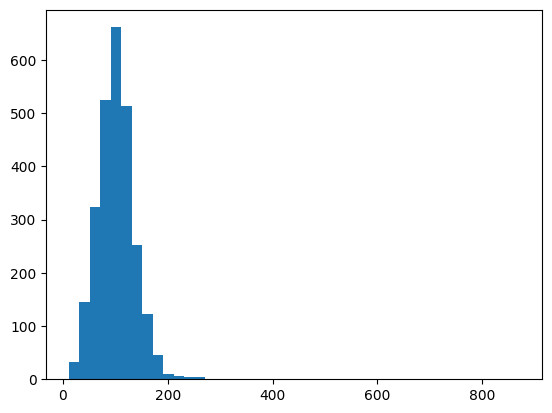

In [ ]:
import matplotlib.pyplot as plt
weights = mst.es['weight']
binwidth = 20
bins = np.arange(min(weights), max(weights) + binwidth, binwidth)
plt.hist(weights, bins=bins)
plt.show()

In [ ]:
triangles = []
gg = g.components().giant()
while len(triangles)<1000:
    points = np.random.randint(1,high=len(gg.vs),size=3)
    try:
        e1, e2, e3 = gg.get_eid(points[0],points[1]), gg.get_eid(points[1],points[2]), gg.get_eid(points[2],points[0])
        weights = [gg.es['weight'][e1],gg.es['weight'][e2],gg.es['weight'][e3]]
        triangles.append(weights)
    except: continue

counter = 0
for i in triangles:
    w1, w2, w3 = i[0], i[1], i[2]
    if w1+w2>w3 and w1+w3>w2 and w3+w2>w1: 
        counter+=1
print(counter/len(triangles))

0.91


In [ ]:
import random
import numpy as np
import igraph as ig

def satisfies_triangle_inequality(triangle):
    w1, w2, w3 = triangle
    return w1 + w2 > w3 and w1 + w3 > w2 and w3 + w2 > w1

giant_component = g.components().giant()
num_triangles = 1000
triangles = []

while len(triangles) < num_triangles:
    random_vertices = random.sample(range(len(giant_component.vs)), 3)
    paths = [
        giant_component.get_shortest_paths(random_vertices[i], random_vertices[(i + 1) % 3], weights='weight')[0]
        for i in range(3)
    ]
    triangle = [giant_component.es[path]['weight'][0] for path in paths]
    
    if satisfies_triangle_inequality(triangle):
        triangles.append(triangle)

percentage = len(triangles) / num_triangles
print(percentage)


1.0


In [ ]:
import numpy as np

triangles = []
gg = g.components().giant()

while len(triangles) < 1000:
    points = np.random.randint(1, high=len(gg.vs), size=3)
    
    try:
        e1, e2, e3 = gg.get_eid(points[0], points[1]), gg.get_eid(points[1], points[2]), gg.get_eid(points[2], points[0])
        weights = [gg.es['weight'][e1], gg.es['weight'][e2], gg.es['weight'][e3]]
        triangles.append(weights)
    except:
        continue

counter = 0

for i in triangles:
    w1, w2, w3 = i[0], i[1], i[2]
    
    if w1 + w2 > w3 and w1 + w3 > w2 and w3 + w2 > w1:
        counter += 1

print(counter / len(triangles))


0.924


In [ ]:
from geopy.geocoders import Nominatim

# Function to get street address near a location given its latitude and longitude
def get_street_address(lat, lon):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        return location.address
    return None

num_edges_to_report = 5

# Convert EdgeView to list and slice
edges_to_report = list(mst.vs)[:num_edges_to_report]

for i, e in enumerate(mst.es):
    source_centroid = mst.vs[e.source]['coordinates']
    target_centroid =  mst.vs[e.target]['coordinates']
    source_address = get_street_address(source_centroid[1], source_centroid[0])
    target_address = get_street_address(target_centroid[1], target_centroid[0])
    
    print("Edge: ", e.source, e.target)
    print("Source Address:", source_address)
    print("Target Address:", target_address)
    print('Distance in miles: {:.3f}\nTime taken: {:.1f}\n---------\n'.format(linalg.norm(mst.vs[e.source]['coordinates'] - mst.vs[e.target]['coordinates'])* 69, e['weight']))
    print()
    if i > 10:
        break

Edge:  0 2
Source Address: Sacred Heart Retreat House - Saint Joseph Campus, 507, North Granada Avenue, Alhambra, Los Angeles County, California, 91801, United States
Target Address: 269, Woodward Avenue, Alhambra, Los Angeles County, California, 91801, United States
Distance in miles: 0.885
Time taken: 129.8
---------


Edge:  0 13
Source Address: Sacred Heart Retreat House - Saint Joseph Campus, 507, North Granada Avenue, Alhambra, Los Angeles County, California, 91801, United States
Target Address: 320, Cordova Street, Alhambra, Los Angeles County, CAL Fire Southern Region, California, 91801, United States
Distance in miles: 0.570
Time taken: 118.3
---------


Edge:  1 2
Source Address: 402, North Marguerita Avenue, Alhambra, Los Angeles County, California, 91801, United States
Target Address: 269, Woodward Avenue, Alhambra, Los Angeles County, California, 91801, United States
Distance in miles: 0.447
Time taken: 90.2
---------


Edge:  1 3
Source Address: 402, North Marguerita Aven

# TSP Approximation

### Check Traingle Inequality

In [ ]:
def is_triangle(sides):
    sides.sort()
    return sides[0] + sides[1] > sides[2]

print('Test:', is_triangle([1,4,2]), is_triangle([3,5,3]))

Test: False True


In [ ]:
def sample_triangles(g, n_samples):
    result = []
    all_vertices = list(g.vs)
    num_vertices = len(all_vertices)

    for _ in range(n_samples):
        triangle_vs = random.sample(all_vertices, 3)
        triangle_ids = [v.index for v in triangle_vs]
        result.append(tuple(triangle_ids))

    return result

In [ ]:
n_samples = 1000  # WARNING: this might take a minute for larger sample sizes
triangles = 0
sets_that_have_3_edges = 0
sampled = sample_triangles(g, n_samples)
for triangle_vs in sampled:
    
    edge_lengths = []
    
    for i in range(3):
        for j in range(i):
            edge = g.get_eid(triangle_vs[i], triangle_vs[j], directed=False, error=False)
            if edge != -1:
                edge_lengths.append(g.es[edge]['weight'])

    if len(edge_lengths) == 3:
        sets_that_have_3_edges += 1
        triangles += is_triangle(edge_lengths)
    
print('Triangle inequality holds by {}%. Out of all sampled, many do not have three edges.'.format(round(100.0 * triangles / n_samples, 1)))
print('Sets that have 3 edges that are triangles: {}%'.format(round(100.0 * triangles / sets_that_have_3_edges, 1)))

Triangle inequality holds by 6.8%. Out of all sampled, many do not have three edges.
Sets that have 3 edges that are triangles: 97.1%


In [ ]:
def preorder_traversal(root, root_parent=None):
    result = [root]

    for child in root.neighbors():
        if child.index != root_parent:
            result.extend(preorder_traversal(child, root.index))

    return result


In [ ]:
def preorder_traversal(root, root_parent=None):
    result = [root]

    neighbors = root.neighbors()
    if root_parent is not None:
        neighbors.remove(root_parent)

    for neighbor in neighbors:
        result.extend(preorder_traversal(neighbor, root))

    return result

### Preorder Traversal Demo

In [ ]:
t = Graph.Tree(20, 3)

visual_style = {}
visual_style["vertex_color"] = 'yellow'
visual_style["vertex_label"] = [v.index for v in t.vs]
visual_style["vertex_label_color"] = 'blue'
visual_style["bbox"] = (200, 200)

plot(t, **visual_style)

AttributeError: ignored

In [ ]:
t = g.spanning_tree(weights=g.es['weight'])
mst_cost = sum(t.es['weight'])

g_multigraph = Graph(directed=True)
g_multigraph.add_vertices(len(t.vs))

edge_indices = []
for e in t.es:
    src, dest = e.source, e.target
    g_multigraph.add_edges([(src, dest), (dest, src)])
    edge_indices.append(g_multigraph.get_eid(src, dest, directed=True, error=False))
    edge_indices.append(g_multigraph.get_eid(dest, src, directed=True, error=False))

visited = [False] * len(g_multigraph.vs)
euler_tour = []

def dfs(v):
    visited[v] = True
    euler_tour.append(v)
    for neighbor in g_multigraph.neighbors(v, mode="OUT"):
        if not visited[neighbor]:
            dfs(neighbor)
            euler_tour.append(v)  # backtrack to current vertex

start_vertex = 0  # Start the DFS from any vertex, here we choose index 0
dfs(start_vertex)

tour_sequence = [v for v in euler_tour if not visited[v]]  # Remove duplicates
tsp = tour_sequence[:-1]  # Remove the duplicate final node

In [ ]:
print('IDs:\n' + '-' * 10 + '\n' + '\n'.join([g.vs[i]['display_name'] for i in tsp]))


IDs:
----------



In [ ]:
print([v.index for v in preorder_traversal(t.vs[0])])

[0, 1, 4, 13, 14, 15, 5, 16, 17, 18, 6, 19, 2, 7, 8, 9, 3, 10, 11, 12]


### Actual Data

In [ ]:
tsp = []
for edge in t.es:
    tsp.extend([edge.source, edge.target])
print('IDs:\n' + '-' * 10 + '\n' + '\n'.join([mst.vs[i]['display_name'] for i in tsp]))

IDs:
----------
Census Tract 480302
Census Tract 480303
Census Tract 480302
Census Tract 480304
Census Tract 480302
Census Tract 480400
Census Tract 480303
Census Tract 480500
Census Tract 480303
Census Tract 480704
Census Tract 480303
Census Tract 480802
Census Tract 480304
Census Tract 480803
Census Tract 480304
Census Tract 480804
Census Tract 480304
Census Tract 480901
Census Tract 480400
Census Tract 480902
Census Tract 480400
Census Tract 480903
Census Tract 480400
Census Tract 481001
Census Tract 480500
Census Tract 481002
Census Tract 480500
Census Tract 481500
Census Tract 480500
Census Tract 481603
Census Tract 480704
Census Tract 481604
Census Tract 480704
Census Tract 481605
Census Tract 480704
Census Tract 481606
Census Tract 480802
Census Tract 481800


In [ ]:
hop_distances = []
for i in range(0, len(tsp) - 1, 2):
    hop_distances.append(min(g.es.select(_between=([tsp[i]], [tsp[i + 1]]))['weight']))

print('Hop distances:\n' + '-' * 10 + '\n' +
      '\n'.join(['{:.3f}'.format(x) for x in hop_distances]))

Hop distances:
----------
250.180
129.765
137.050
140.950
249.960
425.695
354.325
274.665
187.210
373.260
520.820
265.555
447.875
763.930
624.635
616.915
673.815
714.075
386.920


### Measureing Relative Performance Guarantee

In [ ]:
mst_cost = sum(mst.es['weight'])

**bold text**<hr><b><font color="red">WARNING: SLOW!</font></b>

In [ ]:
tsp_cost = 0
for i in range(len(tsp)):
    if i % 100 == 0:
        print(i)
    tsp_cost += min(g.es.select(_between=([tsp[i]], [tsp[(i + 1) % len(tsp)]]))['weight'])


0


In [ ]:
print('MST Cost:', round(mst_cost))
print('TSP Cost:', round(tsp_cost))
print('Ratio:', round(tsp_cost/mst_cost, 2))

MST Cost: 269085
TSP Cost: 15650
Ratio: 0.06


---
TSP results should resemble the following figure

In [ ]:
all_coordinates = np.array(g.vs['coordinates'])
tsp_coordinates = all_coordinates[tsp, :]
tsp_coordinates = np.vstack([tsp_coordinates, tsp_coordinates[0, :]])  # connect the last element back to the first element

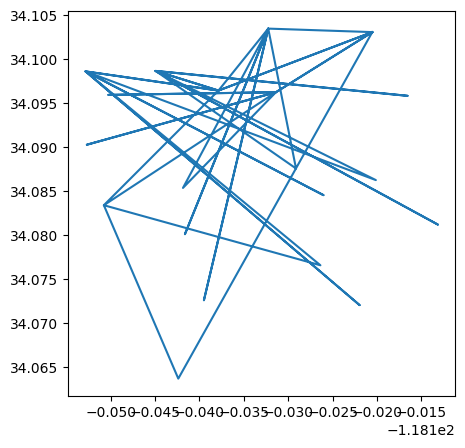

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1],'-')
plt.show()

### Triangulation

In [ ]:
tri = #use the Delaunay function imported above 

In [ ]:
plt.figure(figsize=(15,15))
plt.triplot(coordinates[:, 0], coordinates[:, 1], tri.simplices.copy())
plt.show()

In [ ]:
edges_to_induce = []

for i in range(tri.simplices.shape[0]):
    for col1, col2 in ((0, 1), (1, 2), (0, 2)):
        #add the edges to edges_to_induce


In [ ]:
tri_g = g.subgraph_edges(edges_to_induce)

### Estimate Traffic Flows

In [ ]:
edge_ends = #write here 
sources, targets = #write here 
distances = #write here 
speeds =  # write here   # mph
car_length = 0.003  # (miles)
safety_distances = speeds * (2/3600)  # in miles, derived from 2 sec distance
cars_per_mile = #write here
n_lanes = 2
cars_per_hour = #write here 


In [ ]:
tri_g.es['capacity'] = cars_per_hour

# Max Flow Analysis

In [ ]:
source_coordinates = [-118.5670548, 34.0458901]  # malibu
dest_coordinates = [-118.1819374, 33.759958]  # long beach

### Calculate Max Flow

In [ ]:
print('Number of independent roads:', ) #max flow of graph (inbuilt is okay )
print('Number of cars per hour:', )

### Trimming Large-Distance (Non-Local) Roads

In [ ]:
trim_thresh = 800

In [ ]:
edges_to_induce = tri_g.es.select(weight_le=trim_thresh)
tri_g_trimmed = tri_g.subgraph_edges(edges_to_induce)

### Visualizing Trimming Scheme

<hr><b><font color="red">WARNING: SLOW!</font></b>

In [ ]:
# plot the roads
plt.figure(figsize=(15,15), dpi=200)
for e in tri_g.es:
    v1 = tri_g.vs[e.source]['coordinates']
    v2 = tri_g.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, '#8ab4f7' if e['weight'] < trim_thresh else '#fc9c3c')
    
# mark the source and destination
# source = tri_g.vs.select(display_name=source_address)[0].index
# target = tri_g.vs.select(display_name=dest_address)[0].index
# v1 = tri_g.vs[source_idx]['coordinates']
# v2 = tri_g.vs[dest_idx]['coordinates']
# data = np.vstack([v1, v2])
# x = data[:, 0]
# y = data[:, 1]
# plt.plot(x, y, 'bo')


plt.axis('equal')
plt.show()

In [ ]:
print('Number of independent roads:', ) #max flow of TRIMMED graph
print('Number of cars per hour:', )

### Aside: Let's Get A Bit of Intuition about Data

In [ ]:

plt.subplot(211)
binwidth = 5
bins = np.arange(np.min(distances), np.max(distances) + binwidth, binwidth)
plt.hist(distances, bins=bins)
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances')
plt.show()

plt.subplot(212)
binwidth = 5
bins = np.arange(0, 100 + binwidth, binwidth)
plt.hist(speeds, bins=bins)#distances, bins=bins)
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.title('Histogram of Speeds')
plt.show()

<b>ROAD NETWORK</b>

In [ ]:
road_map = deepcopy(tri_g_trimmed)
len(road_map.vs), len(road_map.es)

Strategy 1 (geodistance_static)

In [ ]:
edge_ends = np.array([[e.source, e.target] for e in road_map.es])
sources, targets = edge_ends[:, 0], edge_ends[:, 1]
distances = #write here 
road_map.es['geo_distance'] = distances
vcount = len(road_map.vs)
max(distances)


In [ ]:
shortest_path_distance = #write here 
shortest_path_distance = np.array(shortest_path_distance)
shortest_path_distance.shape

In [ ]:
actual_geo_distances = np.zeros((vcount,vcount))
actual_geo_distances = None 
differences = None



In [ ]:
ind = #argsort differences to get max value 

In [ ]:
new_static_edges = []
for i in range(40): #40 because there will be repititions (A-> B is same as B-> A)
    if i%2 ==0:
        continue
    newedge = None
    print(#new edge nodes and the difference )
    new_static_edges.append(newedge)

In [ ]:
#add the new_static_edges to our graph. 

road_map_static = deepcopy(tri_g_trimmed) #ensure to use deepcopy
for edg in new_static_edges:
    start = edg[0]
    end = edg[1]
    dist = # which distance to use? 
    road_map_static.add_edge(start, end, weight = dist)

In [ ]:
# plot the roads and highlight our new edges. 
plt.figure(figsize=(15,15), dpi=200)
for e in road_map_static.es:
    start = e.source
    end = e.target
    cur_edge = sorted([start,end])

    v1 = road_map_static.vs[e.source]['coordinates']
    v2 = road_map_static.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    if cur_edge in new_static_edges:
        print(cur_edge)
        plt.plot(x,y,'#FF0000') 
    else:
        plt.plot(x, y, '#8ab4f7')
    
# mark the source and destination
# source = tri_g.vs.select(display_name=source_address)[0].index
# target = tri_g.vs.select(display_name=dest_address)[0].index
# v1 = road_map_static.vs[source_idx]['coordinates']
# v2 = road_map_static.vs[dest_idx]['coordinates']
# data = np.vstack([v1, v2])
# x = data[:, 0]
# y = data[:, 1]
# plt.plot(x, y, 'bo')



plt.axis('equal')
plt.show()

In [ ]:
# A, B >1000, freq:10 ->10,000
#C, D = 500 , 10,000 - > 500*10,000

Strategy 2 (geo_distance, static, with_frequency)

In [ ]:
np.random.seed(2022)
frequencies = np.random.randint(1,1001, (vcount,vcount) )
frequencies.shape

In [ ]:
difference_frequency = np.multiply(differences,frequencies)

In [ ]:
ind = #argsort differences to get max value 

In [ ]:
for i in range(40): #40 because there will be repititions (A-> B is same as B-> A)
    if i%2 ==0:
        continue
    print(#new edge nodes and the difference )


Stategy 3 : (geo_distance, Dynamic)

In [ ]:
road_map_dynamic = deepcopy(road_map)
budget = 20
new_dynamic_edges = []
for i in range(budget):
    
    #get current graph shortest paths 
    #get differences 
    #sort differences and pich the highest         
    # get vertices of new edge to build. Build the edge and print its vertices. 
    new_egde = None
    print(new_Edge, difference_between_new_edge_vertices  )
    new_dynamic_edges.append(new_edge )

    #add the new edge 
    new_distance = #Get this 
    road_map_dynamic.add_edge(start, end, weight = -1 , geo_distance = new_distance)

In [ ]:
# plot the roads
plt.figure(figsize=(15,15), dpi=200)
for e in road_map_dynamic.es:
    start = e.source
    end = e.target
    cur_edge = sorted([start,end])

    v1 = road_map_dynamic.vs[e.source]['coordinates']
    v2 = road_map_dynamic.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    if cur_edge in new_dynamic_edges:
        print(cur_edge)
        plt.plot(x,y,'#FF0000')
    else:
        plt.plot(x, y, '#8ab4f7' )
    
# mark the source and destination
# source = tri_g.vs.select(display_name=source_address)[0].index
# target = tri_g.vs.select(display_name=dest_address)[0].index
# v1 = road_map.vs[source_idx]['coordinates']
# v2 = road_map.vs[dest_idx]['coordinates']
# data = np.vstack([v1, v2])
# x = data[:, 0]
# y = data[:, 1]
# plt.plot(x, y, 'bo')


plt.axis('equal')
plt.show()

strategy 4 : (travel_time, static)

In [ ]:
road_map_time = deepcopy(tri_g_trimmed)

In [ ]:
#get current shortest times
#get current shortest distances 
#speed = shortest_distance/time
time_diffence = current_shortest_time - actual_geo_distance/speed  
#explicitly set time_diffence to 0 for self edges, to avoid divide_by_zero error

time dynamic

In [ ]:
road_map_time_dynamic = deepcopy(tri_g_trimmed)

In [ ]:
budget = 20
new_dynamic_time_edges = []

for i in range(budget):

    

## Question 15
Max Capacity =• Each degree of latitude and longitude ≈ 69 miles
• Car length ≈ 5 m = 0.003 mile
• Cars maintain a safety distance of 2 seconds to the next car
• Each road has 2 lanes in each direction

2v/(.003+v/`1800)


##Question 14/16

In [ ]:
import numpy as np
import json
from scipy.spatial import Delaunay
from igraph import Graph

lat_long = {}

with open('/content/drive/MyDrive/los_angeles_censustracts.json', 'r') as f:
    d = json.load(f)
    features = d['features']

    for feature in features:
        latitude = 0.0
        longitude = 0.0

        geometry_type = feature['geometry']['type']
        coordinates = np.array(feature['geometry']['coordinates'][0]) if geometry_type == 'Polygon' else np.array(
            feature['geometry']['coordinates'][0][0])

        for coordinate in coordinates:
            latitude += coordinate[1]
            longitude += coordinate[0]

        latitude /= len(coordinates)
        longitude /= len(coordinates)

        movement_id = feature['properties']['MOVEMENT_ID']
        display_name = feature['properties']['DISPLAY_NAME']

        lat_long[movement_id] = (display_name, latitude, longitude)

lat = []
lon = []
for i in range(1, len(lat_long) + 1):
    lat.append(lat_long[str(i)][1])
    lon.append(lat_long[str(i)][2])

lat_lon = tuple(zip(lat, lon))
delaunay_out = Delaunay(lat_lon)

edges = delaunay_out.simplices
g_del = Graph.TupleList(edges, directed=False, vertex_name_attr='name')

f.close()


Max Capacity =• Each degree of latitude and longitude ≈ 69 miles
• Car length ≈ 5 m = 0.003 mile
• Cars maintain a safety distance of 2 seconds to the next car
• Each road has 2 lanes in each direction

2v/(.003+v/`1800)


In [ ]:
malibu= [34.026, -118.78]
long_beach =  [33.77, -118.18]
velocity=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))
max_cars=2*velocity/(.003+velocity/1800)

min_long_beach=np.inf
min_malibu=np.inf
long_beach_node=0
malibu_node=0
for i in range(1,len(lat_lon)):
    long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
    malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i

deg_dist_mal = g_del.degree(malibu_node,mode='out')
deg_dist_lb = g_del.degree(long_beach_node,mode='in')
paths = g_del.adhesion(long_beach_node,malibu_node)
        




In [ ]:
print(max_cars)
print(deg_dist_mal )
print(deg_dist_lb)
print(paths)

3214.3687557752646
4
5
4


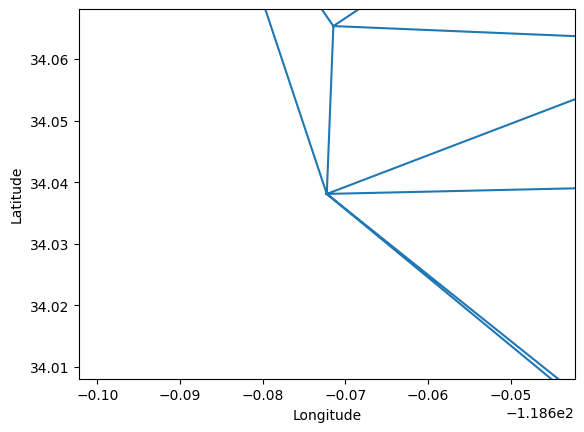

In [ ]:
plt.triplot(lon, lat, delaunay_out.simplices)
plt.ylim(lat_lon[malibu_node][0]-0.03,lat_lon[malibu_node][0]+0.03)
plt.xlim(lat_lon[malibu_node][1]-0.03,lat_lon[malibu_node][1]+0.03)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot(lon[malibu_node], lat[malibu_node])
plt.show()

## Question 17

In [ ]:
g_temp = Graph()
g_temp.add_vertices(len(delaunay_out.points))

# Set vertex attributes for latitude and longitude
g_temp.vs['lat'] = lat
g_temp.vs['lon'] = lon

coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence

fake_edges = set()

for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp.vs[edge[0]]
        v2 = g_temp.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp.add_edge(edge[0], edge[1])
        else:
            fake_edges.add(edge)


#g_temp.delete_edges(fake_edges)


In [ ]:
thresh_plot = [] 
for simplex in delaunay_out.simplices:
    found_edge = False
    for edge in fake_edges:
        vertex1, vertex2 = edge
        if vertex1 in simplex and vertex2 in simplex:
            found_edge = True
            break
    
    if not found_edge:
        thresh_plot.append(simplex)

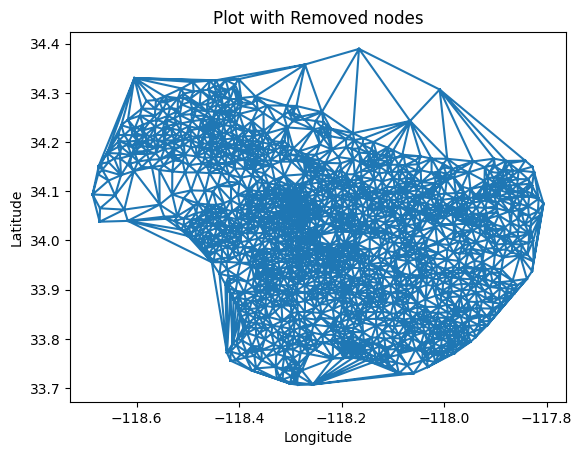

In [ ]:

plt.triplot(lon, lat, thresh_plot)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with Removed nodes')
plt.show()

In [ ]:
for ind in fake_edges:
  g_temp.delete_edges(ind)

In [ ]:
type(thresh_plot)

list

## Q 18 relies on 13

In [ ]:
# malibu= [34.026, -118.78]
# long_beach =  [33.77, -118.18]
# velocity=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))
# max_cars=2*velocity/(.003+velocity/1800)

# min_long_beach=np.inf
# min_malibu=np.inf
# long_beach_node=0
# malibu_node=0
# for i in range(1,len(lat_lon)):
#     long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
#     malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
#     if long_beach_closest<min_long_beach:
#         min_long_beach=long_beach_closest
#         long_beach_node=i
#     if malibu_closest<min_malibu:
#         min_malibu=malibu_closest
#         malibu_node=i

# deg_dist_mal = g_del.degree(malibu_node,mode='out')
# deg_dist_lb = g_del.degree(long_beach_node,mode='in')
# paths = g_del.adhesion(long_beach_node,malibu_node)
        




In [ ]:
print(g_temp.adhesion(long_beach_node,malibu_node)-1)
print(g_temp.degree(malibu_node,mode='out')-1)
print(g_temp.degree(long_beach_node,mode='in')-1)

6
6
11


In [ ]:

malibu= [34.026, -118.78]
long_beach =  [33.77, -118.18]
velocity=(69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2))
max_cars=2*velocity/(.003+velocity/1800)

min_long_beach=np.inf
min_malibu=np.inf
long_beach_node=0
malibu_node=0
for i in range(1,len(lat_lon)):
    long_beach_closest=np.sqrt(((lat_lon[i][0])-long_beach[0])**2+((lat_lon[i][1])-long_beach[1])**2)
    malibu_closest=np.sqrt((malibu[0]-lat_lon[i][0])**2+(malibu[1]-lat_lon[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i

deg_dist_mal = g_del.degree(malibu_node,mode='out')
deg_dist_lb = g_del.degree(long_beach_node,mode='in')
paths = g_del.adhesion(long_beach_node,malibu_node)
        




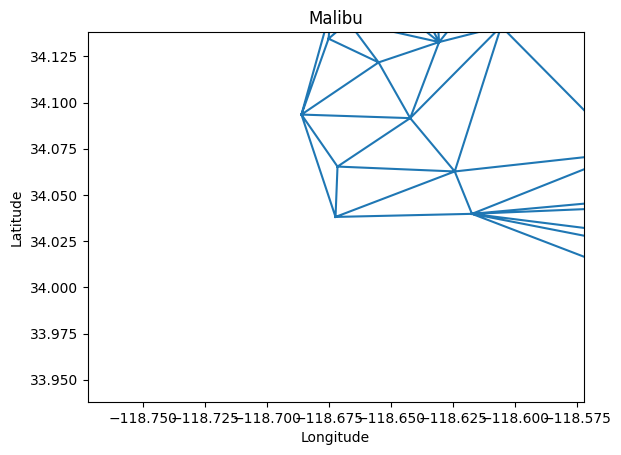

In [ ]:
plt.triplot(lon, lat, thresh_plot)
plt.ylim(lat_lon[malibu_node][0]-0.1,lat_lon[malibu_node][0]+0.1)
plt.xlim(lat_lon[malibu_node][1]-0.1,lat_lon[malibu_node][1]+0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Malibu')
plt.plot(lon[malibu_node], lat[malibu_node])

## Q 19

In [ ]:
import numpy as np
import igraph as ig
from itertools import combinations
from operator import itemgetter

def calculate_euclidean_distance(v1, v2):
    return np.sqrt((v1['lat'] - v2['lat']) ** 2 + (v1['lon'] - v2['lon']) ** 2)

def calculate_extra_distance(v1, v2):
    shortest_distance = g_temp.shortest_paths_dijkstra(source=v1.index, target=v2.index, weights='weight')[0][0]
    euclidean_distance = calculate_euclidean_distance(v1, v2)
    extra_distance = shortest_distance - euclidean_distance
    return extra_distance

g_temp = ig.Graph()
g_temp.add_vertices(len(delaunay_out.points))

g_temp.vs['lat'] = lat
g_temp.vs['lon'] = lon

# Add edges to the graph based on coordinate threshold
coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence
for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp.vs[edge[0]]
        v2 = g_temp.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp.add_edge(edge[0], edge[1], weight=distance)

# Calculate extra distance between all pairs of points
extra_distances = []
vertices = g_temp.vs()
for v1, v2 in combinations(vertices, 2):
    extra_distance = calculate_extra_distance(v1, v2)
    extra_distances.append((v1.index, v2.index, extra_distance))

# Sort the extra distances in descending order
extra_distances.sort(key=itemgetter(2), reverse=True)

# Get the top 20 pairs with highest extra distance
top_pairs = extra_distances[:20]

# Print the source and destination of the top pairs
for pair in top_pairs:
    source = vertices[pair[0]]
    destination = vertices[pair[1]]
    print(f"Source: ({source['lat']}, {source['lon']}), Destination: ({destination['lat']}, {destination['lon']})")

# Create new edges in the graph for the top pairs
for pair in top_pairs:
    source_index = pair[0]
    destination_index = pair[1]
    g_temp.add_edge(source_index, destination_index)

# Plot the resultant graph on actual coordinates
layout = g_temp.layout_auto()
visual_style = dict(layout=layout, vertex_size=10)
ig.plot(g_temp, **visual_style)


<ipython-input-42-ee8c247e039f>:12: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  shortest_distance = g_temp.shortest_paths_dijkstra(source=v1.index, target=v2.index, weights='weight')[0][0]


Source: (34.03809095384618, -118.67225393333337), Destination: (33.75689578693178, -118.40648371022725)
Source: (34.03809095384618, -118.67225393333337), Destination: (33.774103109090916, -118.41714115454548)
Source: (34.03809095384618, -118.67225393333337), Destination: (33.75546574545454, -118.41678392121217)
Source: (34.03809095384618, -118.67225393333337), Destination: (33.77153057777776, -118.4237928111111)
Source: (33.75689578693178, -118.40648371022725), Destination: (34.06533878290219, -118.67145511923503)
Source: (34.09347549818183, -118.68599468727271), Destination: (33.93756910909091, -117.82852631818183)
Source: (33.774103109090916, -118.41714115454548), Destination: (34.06533878290219, -118.67145511923503)
Source: (33.75689578693178, -118.40648371022725), Destination: (34.09347549818183, -118.68599468727271)
Source: (34.09155097353136, -118.64214877275657), Destination: (33.93756910909091, -117.82852631818183)
Source: (33.774103109090916, -118.41714115454548), Destination:

AttributeError: ignored

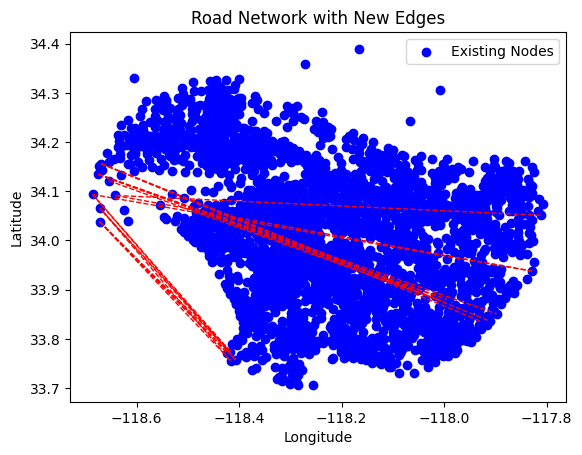

In [ ]:
x = g_temp.vs['lon']
y = g_temp.vs['lat']

# Plot the graph nodes
plt.scatter(x, y, color='blue', label='Existing Nodes')
top_edges = [(pair[0], pair[1]) for pair in top_pairs]

# Plot the new edges
for edge in top_edges:
    v1_x, v1_y = x[edge[0]], y[edge[0]]
    v2_x, v2_y = x[edge[1]], y[edge[1]]
    plt.plot([v1_x, v2_x], [v1_y, v2_y], color='red', linestyle='dashed', linewidth=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network with New Edges')
plt.legend()
plt.show()

## Q20

In [ ]:
g_temp_2 = Graph()
g_temp_2.add_vertices(len(delaunay_out.points))

# Set vertex attributes for latitude and longitude
g_temp_2.vs['lat'] = lat
g_temp_2.vs['lon'] = lon

coordinate_threshold = 19.2 / 69  # Distance threshold for edge existence

fake_edges = set()

for simplex in delaunay_out.simplices:
    edges = [(simplex[0], simplex[1]), (simplex[0], simplex[2]), (simplex[1], simplex[2])]
    for edge in edges:
        edge = tuple(sorted(edge))
        v1 = g_temp_2.vs[edge[0]]
        v2 = g_temp_2.vs[edge[1]]
        v1_lat, v1_lon = v1['lat'], v1['lon']
        v2_lat, v2_lon = v2['lat'], v2['lon']
        distance = np.sqrt((v1_lat - v2_lat) ** 2 + (v1_lon - v2_lon) ** 2)
        if distance < coordinate_threshold:
            g_temp_2.add_edge(edge[0], edge[1])
        else:
            fake_edges.add(edge)


#g_temp.delete_edges(fake_edges)


In [ ]:
for ind in fake_edges:
  g_temp_2.delete_edges(ind)

Streaming output truncated to the last 5000 lines.
(2138, 2628)
(2628, 2698)
(2138, 2698)
(2318, 2319)
(2140, 2319)
(2140, 2318)
(2318, 2319)
(546, 2318)
(546, 2319)
(546, 2319)
(546, 2320)
(2319, 2320)
(548, 2320)
(548, 2321)
(2320, 2321)
(547, 548)
(548, 2320)
(547, 2320)
(548, 549)
(549, 2321)
(548, 2321)
(547, 548)
(547, 549)
(548, 549)
(1749, 2352)
(1750, 2352)
(1749, 1750)
(1745, 2350)
(1747, 2350)
(1745, 1747)
(1745, 2350)
(1745, 2323)
(2323, 2350)
(185, 2345)
(185, 2349)
(2345, 2349)
(185, 2345)
(2342, 2345)
(185, 2342)
(2345, 2349)
(2347, 2349)
(2345, 2347)
(2342, 2345)
(2345, 2347)
(2342, 2347)
(1722, 2341)
(184, 1722)
(184, 2341)
(1722, 2341)
(1214, 2341)
(1214, 1722)
(2341, 2342)
(184, 2341)
(184, 2342)
(2340, 2343)
(2340, 2342)
(2342, 2343)
(2339, 2340)
(2340, 2343)
(2339, 2343)
(2340, 2341)
(2341, 2342)
(2340, 2342)
(2340, 2341)
(2339, 2340)
(2339, 2341)
(2333, 2337)
(2334, 2337)
(2333, 2334)
(2337, 2343)
(2337, 2338)
(2338, 2343)
(2336, 2337)
(2336, 2338)
(2337, 2338)
(2

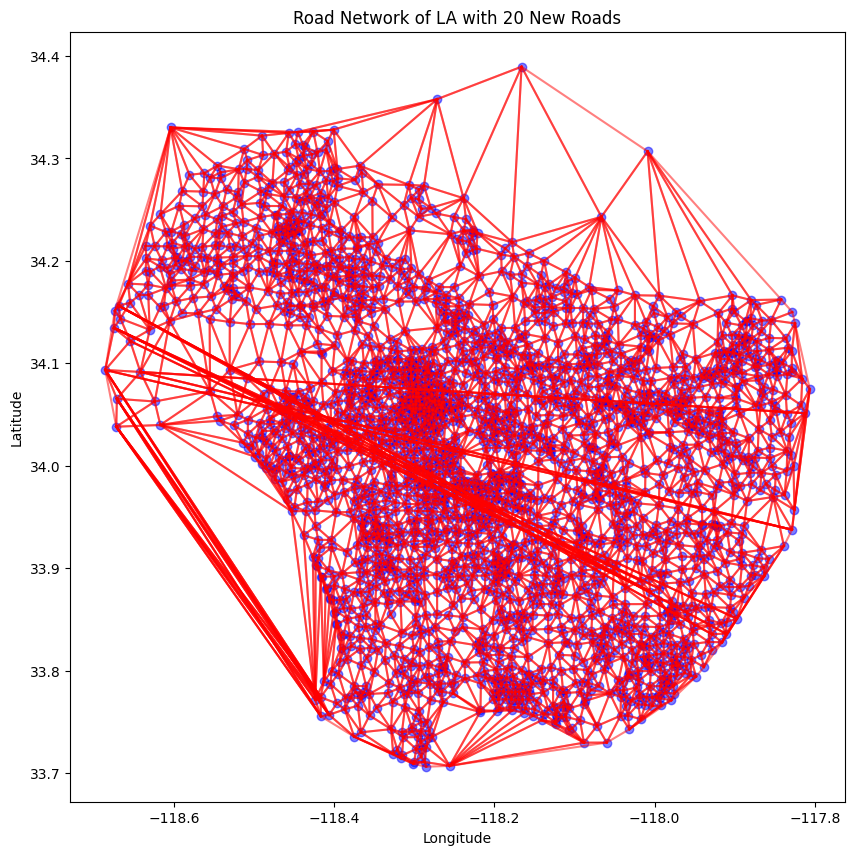

In [ ]:
import random
import numpy as np

# Generate random frequencies between 1 and 1000 for each pair of points
frequencies = {}
for v in range(len(lat)):
    for s in range(v + 1, len(lat)):
        frequencies[(v, s)] = random.randint(1, 1000)

# Calculate the weighted extra distance for each pair of points
weighted_extra_distances = []
for pair in top_pairs:
    v, s = pair[0], pair[1]
    frequency = frequencies[(v, s)]
    extra_distance = np.sqrt((lon[v] - lon[s]) ** 2 + (lat[v] - lat[s]) ** 2)
    weighted_extra_distance = extra_distance * frequency
    weighted_extra_distances.append((pair, weighted_extra_distance))

# Sort the weighted extra distances in descending order and select the top 20 pairs
top_weighted_pairs = sorted(weighted_extra_distances, key=lambda x: x[1], reverse=True)[:20]

# Print the source and destination of the top weighted pairs
for pair, weighted_distance in top_weighted_pairs:
    v, s = pair[0], pair[1]
    print(f"Source: {v}, Destination: {s}")

# Create the new edges in the graph
for pair, _ in top_weighted_pairs:
    v, s = pair[0], pair[1]
    g_temp.add_edge(v, s)

# Plot the resultant graph on actual coordinates as before
plt.figure(figsize=(10, 10))
plt.scatter(lon, lat, color='blue', alpha=0.5)

new_edges = [g_temp.es[idx].tuple for idx in range(g_temp.ecount())]
for edge in new_edges:
    print(edge)
    v1 = edge[0]
    v2 = edge[1]
    plt.plot([lon[v1], lon[v2]], [lat[v1], lat[v2]], color='red', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network of LA with 20 New Roads')
plt.show()


TypeError: ignored

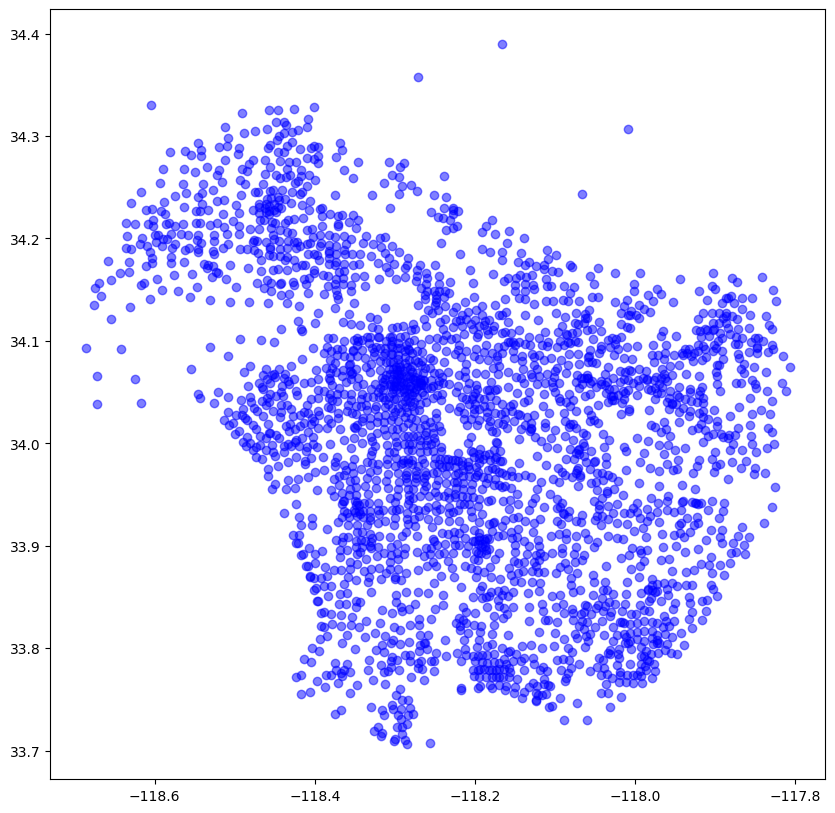

In [ ]:
# Sort the pairs based on weighted extra distance in descending order
top_pairs = sorted(weighted_extra_distances, key=lambda x: x[1], reverse=True)[:20]

# Get the source and destination vertices of the top 20 pairs
top_edges = [(pair[0], pair[1]) for pair in top_pairs]

# Add the top 20 edges to the graph
for edge in top_edges:
    g_temp_2.add_edge(edge[0][0], edge[0][1])

# Plot the resultant graph with only the 20 new roads
plt.figure(figsize=(10, 10))
plt.scatter(lon, lat, color='blue', alpha=0.5)

for edge in top_edges:
    v1 = edge[0]
    v2 = edge[1]
    plt.plot([g_temp_2.vs[v1]['lon'], g_temp_2.vs[v2]['lon']], [g_temp_2.vs[v1]['lat'], g_temp_2.vs[v2]['lat']], color='red', alpha=0.5)


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network of LA with 20 New Roads')
plt.show()


In [ ]:
edge[0]

[-118.67506014705866, -118.01699407746476, -118.12053321311474]